## Exercise set 4: the generalized random forest

In this exercise set we will be working with the [generalized random forest](https://github.com/grf-labs/grf) by Athey et al. The package is written for the R programming language, and while there is a R-to-python interface in [rpy2](https://rpy2.bitbucket.io/) it can be tricky to get working. If you run into trouble, you can consider saving your data to a csv file and work directly in [R](https://www.r-project.org/) through [Rstudio](https://rstudio.com/products/rstudio/download/). 

In [1]:
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

To highlight the usefulness of GRF we will be working with synthetic data in this exercise. In particular we will synthetically add a treatment effect to a dataset in which there otherwise is none. Furthermore we will make this effect heterogeneous by adding noise, and by making it depend on a single continuous variable as well as a categorical variable. 

>**Ex. 4.1.1:** Complete the code below to simulate data according to
$$
T = U(0,1) > 0.5 \\ 
Y(T=0) = X\beta + \epsilon \\ 
\tau(X) =  \begin{cases}
        \frac{10}{1 + e^{-\gamma X_0}} + \nu & D = 0\\ 
        \nu & D = 1
        \end{cases}\\ 
Y(T=1) = Y(0) + \tau(X) \\ 
$$
where $\epsilon, \nu$ are simply noise terms distributed according to $\mathcal{N}(0,1)$ and $\beta$ is an `N_FEATURES` vector of random parameters. $\gamma$ is a scalar parameter.


In [2]:
N_SAMPLES = 10000
N_FEATURES = 5
GAMMA = 3
BETA = np.random.uniform(0,1, size = N_FEATURES)
eps = np.random.normal(size = N_SAMPLES) # eps and v is a noise term distributed according to std.n.dist 
v = np.random.normal(size = N_SAMPLES)

X = np.random.normal(size = (N_SAMPLES, N_FEATURES))
D = np.random.choice([0,1], size = N_SAMPLES)
# Defining XO and T 
X0 = X[:,0] # all rows in the first column 
T = np.array(np.random.uniform(0,1, size = N_SAMPLES) > 0.5).astype(int) # uniformly distributed between 0 and 1. If greater than 0.5 then 1 else 0.  

Y0 = X @ BETA + eps 
Tau = 10*(1-D)/(1+np.exp(-GAMMA*X0)) + v # when D is 1 the numerator is 0 
Y1 = Y0 + Tau
y = Y0 + T*(Y1-Y0) #the observed y 


**Ex. 4.1.2:** Create a two-subplot figure, and plot $Y(0)$ and $Y(1)$ in one subplot against $X_0$. Plot $\tau(x)$ against $X_0$ in the other subplot. What do you see? Why do we observe $\tau=0$ in many cases?

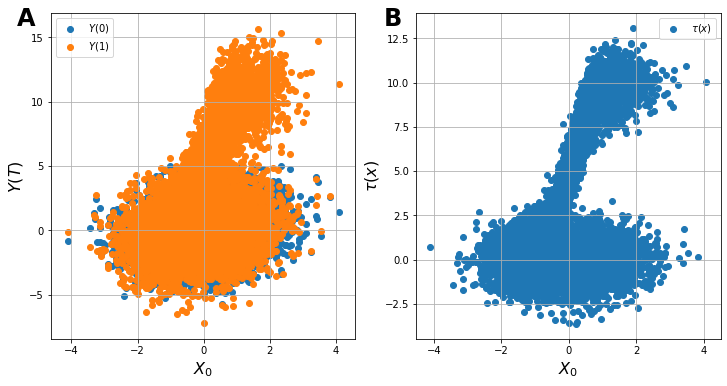

In [3]:
#Set the subplot (1 row with 2 columns)
fig, ax = plt.subplots(1,2, figsize = (12,6))

#The first subplot plots Y0 and Y1 against X0. 
ax[0].scatter(X0, Y0, label = '$Y(0)$')
ax[0].scatter(X0, Y1, label = '$Y(1)$')

ax[0].set_xlabel('$X_0$', fontsize = 16) 
ax[0].set_ylabel('$Y(T)$', fontsize = 16) 
ax[0].legend()
ax[0].grid(True)

#The second subplot plots Tau aginst X0. 
ax[1].scatter(X0, Tau, label = r'$\tau(x)$')

ax[1].set_xlabel('$X_0$', fontsize = 16) 
ax[1].set_ylabel(r'$\tau(x)$', fontsize = 16)
ax[1].legend()
ax[1].grid(True)

#Adding the "titles"

fig.text(0.085,0.85, 'A',fontsize = 24, fontweight = 'bold')
fig.text(0.51,0.85, 'B',fontsize = 24, fontweight = 'bold')

#Saving to directory 
plt.savefig('Fig1_ex5.pdf')




>**Ex 4.1.3.** Import `statsmodels` and estimate a simple linear regression
$$
y = \alpha + \delta_0 T + \sum_k \beta_k X_k + \epsilon
$$
>What is your estimate of $\hat{\delta}_0$? How does this number fit with the figures you drew in the previous exercise? Do you have any suggestions for improving the estimate of the model, comment on whether your improvements would provide unbiased estimates of $\tau$? 
>
> **Bonus:** fit your improved model, and relate the parameters you estimate to the figure you plotted in the previous question.

In [4]:
from statsmodels.formula.api import ols

df = pd.concat( [
pd.DataFrame(X, columns=[f'X{i}' for i in range(N_FEATURES)]), 
pd.DataFrame(T, columns = ['T']),
pd.DataFrame(y, columns = ['y'])
],
axis = 1)

#Estimating the model 

model = ols('y ~ T + X0 + X1 + X2 + X3 + X4', df)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     961.8
Date:                Sun, 22 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:26:31   Log-Likelihood:                -23932.
No. Observations:               10000   AIC:                         4.788e+04
Df Residuals:                    9993   BIC:                         4.793e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0041      0.037      0.110      0.913      -0.069       0.077
T              2.3875      0.053     45.023      0.000       2.284       2.491
X0             1.1680      0.027     43.431      0.000       1.115       1.221
X1             0.5780      0.026     21.942      0.000       0.526       0.630
X2             0.5639      0.026     21.637      0.000       0.513       0.615
X3             0.7719      0.027     29.076      0.000       0.720       0.824
X4             0.3182      0.027     11.923      0.000       0.266       0.370
==============================================================================
Omnibus:                      975.733   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1382.072
Skew:                           0.772   Prob(JB):                    7.71e-301
Kurtosis:                       3.965   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I obtain a delta_hat value of 2.46 close to the expected 2.5. The coefficient is significant on a 97.5% confidence interval level. 

>**Ex. 4.1.4:** For this question we will need to move into R (or use rpy2). If you are working in python you can skip this step, otherwise do the following. 
>
> Save a dataframe, containing $X$, $y$, $T$, and $D$ as a csv file on your computer.

In [5]:
#I have not tried to use rpy2. Instead I will work in R - (What is the most optimal?)

# Saving the dataframe so it contains X, y, T and D. 

df = pd.concat( [
pd.DataFrame(X, columns=[f'X{i}' for i in range(N_FEATURES)]), 
pd.DataFrame(T, columns = ['T']),
pd.DataFrame(y, columns = ['y']),
pd.DataFrame(D, columns = ['D'])
],
axis = 1)

df.to_csv('Ex5_simulated_data.csv', index = False)

>**Ex. 4.1.5:** Open up R and read the data you just saved into a dataframe(or work in rpy2). Install and load the two libraries `tidyverse` and `grf`.
>
> _Hint:_ to install the required packages. run this:
> ```R
> install.packages("tidyverse")
> install.packages("grf")
> ```

In [6]:
# See R script 

>**Ex. 4.1.5:** Copy the following code into R to split your dataframe into two matrices, `X`, and `y`. Implement the exact same procedure to create a third matrix `W` which contains the treatment indicator (**Note** `T` is a reserved name in R, so name your third matrix `W`).
>```R
>X <- df %>%
  select(X0, X1, X2, X3, X4, D) %>% 
  as.matrix()
>
>y <- df %>%
  select(y) %>% 
  as.matrix()
>```
> Finally spend some time poking around the [GRF documentation](https://github.com/grf-labs/grf). See if you can figure out how to estimate a GRF model, once you have the three matrices you need (this is way simpler than you might expect).

In [7]:
# See R script 

>**Ex.4.1.6:** Estimate a causal forest model using the GRF package, and store the result in a new variable `cf`. Then use the following line to create a dataframe of predicted treatment effects on the same data that you trained the model on. 
>```R
>cf <- # Estimate a generalized RF model aimed at treatment effects.
>tau <- predict(cf, X)
>```
> Once you have your individual treatment effects, run the following line, to save them in a csv file. 
> ```R
> write.csv(tau, "individual_treatment_effects.csv")
> ```

In [8]:
# See R script 

>**Ex.4.1.6:** This concludes our venture into R. Now load the treatment effects into a pandas dataframe, and plot a scatterplot of the estimated individual treatment effects against the simulated "true" ITE's `Tau` that you produced in the beginning of this exercise set.

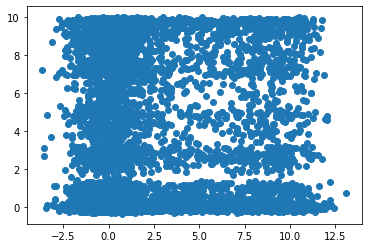

In [43]:
# Load data 
R_data = pd.read_csv('individual_treatment_effects.csv')
R_data.head()


# Plot scatterplot
plt.scatter(Tau, R_data['predictions'])
